### <div align="center">***MODEL BUILDING AND TRAINING***</div>

### ***Import libraries and modules***

In [ ]:
# Import required libraries

import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="_distutils_hack")
warnings.filterwarnings("ignore", category=FutureWarning, module="mlflow.data")

### ***Preprocessing dataset for Modeling***

In [2]:
# Load Clean Dataset
fe_dataset = pd.read_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Amazon_DeliveryTime_Prediction\Data\Processed\EDA_dataset.csv')

In [3]:
df = fe_dataset.copy()

# Interactive features
df['Traffic_Area'] = df['Traffic'].astype(str) + "_" + df['Area'].astype(str)
df['Area_Vehicle'] = df['Area'].astype(str) + "_" + df['Vehicle'].astype(str)
df['Weather_Area'] = df['Weather'].astype(str) + "_" + df['Area'].astype(str)

df['Is_Peak_Hours'] = df['Order_Hour'].apply(lambda x: 1 if (17 <= x <= 23) else 0) # Create peak hours from order hours
df['Is_Urban'] = df['Area'].apply(lambda x: 1 if x in ['Urban', 'Metropolitan'] else 0) # Collapse to Binary (Urban vs Non-Urban)

df = df.drop(["Delay_Time_M", "Order_Month", "Order_DayOfWeek", "Order_Day", "Is_Weekend"], axis=1) # Drop features with no predictive power
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43648 entries, 0 to 43647
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43648 non-null  int64  
 1   Agent_Rating   43648 non-null  float64
 2   Weather        43648 non-null  object 
 3   Traffic        43648 non-null  object 
 4   Vehicle        43648 non-null  object 
 5   Area           43648 non-null  object 
 6   Delivery_Time  43648 non-null  int64  
 7   Category       43648 non-null  object 
 8   Distance_km    43648 non-null  float64
 9   Order_Hour     43648 non-null  int64  
 10  Traffic_Area   43648 non-null  object 
 11  Area_Vehicle   43648 non-null  object 
 12  Weather_Area   43648 non-null  object 
 13  Is_Peak_Hours  43648 non-null  int64  
 14  Is_Urban       43648 non-null  int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 5.0+ MB


#### ***Train-Val-Test split*** 

In [4]:
# Define target
TARGET = "Delivery_Time"
train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=42) # First split Train (70%) & Val+Test (30%)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42) # Second split Validation (15%) & Test (15%)

X_train, y_train = train_df.drop(columns=TARGET), train_df[TARGET]
X_val, y_val = val_df.drop(columns=TARGET), val_df[TARGET]
X_test, y_test = test_df.drop(columns=TARGET), test_df[TARGET]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (30553, 14), Val: (6547, 14), Test: (6548, 14)


#### ***Prepocessing Pipeline***

#### ***Outlier Handling & Skewness Correction***

***As observed from univariate analysis, Delivery_Time, Distance_km and Order_Hour are skewed with outliers.***
- ***Delivery_Time (target):*** left untouched 
- ***Order_Hour:*** bimodal, temporal pattern → keep raw
- ***Agent_Rating:*** bounded [1–5], skew due to natural bias → keep raw 
- ***Distance_km:*** extreme skew & heavy-tailed → cap + log transform (if needed) ✅

#### ***Encode categorical features***
- ***Define low & high cardinality feature groups***
- Apply One-hot Encoding for low cardinality features
- Apply Target Encoding for high cardinality features (Interactive features)

#### ***Scaling numerical features + target-encoded features***
- Apply ***StandardScalar()*** on numerical + target-encoded features

In [5]:
# Outlier & Skew transformer
class OutlierSkewHandler(BaseEstimator, TransformerMixin):
    def __init__(self, features, skew_threshold=1.0, quantile=0.99):
        self.features = features
        self.skew_threshold = skew_threshold
        self.quantile = quantile
        self.upper_limits_ = {}
        self.log_features_ = []

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.features:
            self.upper_limits_[col] = X[col].quantile(self.quantile)
            capped = np.where(X[col] > self.upper_limits_[col], self.upper_limits_[col], X[col])
            if pd.Series(capped).skew() > self.skew_threshold:
                self.log_features_.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.features:
            X[col] = np.where(X[col] > self.upper_limits_[col], self.upper_limits_[col], X[col])
            if col in self.log_features_:
                X[col] = np.log1p(X[col])
        return X

In [6]:
# Define Preprocessing pipeline

# Feature groups
low_card_feats  = ["Weather", "Traffic", "Vehicle", "Area"]
high_card_feats = ["Category", "Traffic_Area", "Area_Vehicle", "Weather_Area"]
num_feats = ["Agent_Age", "Agent_Rating", "Distance_km", "Order_Hour"]
no_scaling_feats = ["Is_Peak_Hours", "Is_Urban"]

# Custom transformers
outlier_skew = OutlierSkewHandler(features=["Distance_km"], skew_threshold=1.0)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
target_enc = TargetEncoder(cols=high_card_feats)

# Column transformer (numerics + OHE)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats + high_card_feats),
        ("ohe", ohe, low_card_feats),
        ("binary", "passthrough", no_scaling_feats) 
    ],
    remainder="drop"  
)

# Full preprocessing pipeline
full_preprocessing_pipeline = Pipeline(steps=[
    ("outlier_skew", outlier_skew),
    ("encode_target", target_enc),
    ("preproc", preprocessor)
])

In [7]:
# Wrapper: preprocessing + model
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessing", full_preprocessing_pipeline),
        ("model", model)
    ])

### ***Setup DagsHub MLflow***

In [8]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load variables from .env file
load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("Amazon_Delivery_time_Prediction")

2025/10/03 11:36:58 INFO mlflow.tracking.fluent: Experiment with name 'Amazon_Delivery_time_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/4d41e3652e57425eb2f3b09621b74c54', creation_time=1759471618868, experiment_id='0', last_update_time=1759471618868, lifecycle_stage='active', name='Amazon_Delivery_time_Prediction', tags={}>

### ***Model Building, Training & Evaluation***

In [9]:
# Metrics helper functions
def metrics_report(y_true, y_pred):
    return {
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }

def print_eval(name, y_true, y_pred):
    m = metrics_report(y_true, y_pred)
    print(f"{name} -> RMSE: {m['rmse']:.4f} | MAE: {m['mae']:.4f} | R2: {m['r2']:.4f}")

#### ***Baseline Models***

In [10]:
# Define baseline models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

In [11]:
results = {}

for name, model in models.items():
    pipe = make_pipeline(model)  # Wrap model with preprocessing pipeline

    with mlflow.start_run(run_name=name):

        # Fit model
        pipe.fit(X_train, y_train)

        # Predictions
        preds_train = pipe.predict(X_train)
        preds_val = pipe.predict(X_val)

        # Metrics
        train_metrics = metrics_report(y_train, preds_train)
        val_metrics = metrics_report(y_val, preds_val)

        # Print results
        print(f"\n=== {name} ===")
        print_eval("Train", y_train, preds_train)
        print_eval("Val", y_val, preds_val)

        # Log metrics & params
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({f"train_{k}": v for k, v in train_metrics.items()})
        mlflow.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})

        # Log feature names used in this pipeline
        try:
            col_trans = pipe.named_steps["preprocessing"].named_steps["preproc"]
            feature_names = []
            for t_name, trans, cols in col_trans.transformers_:
                if hasattr(trans, "get_feature_names_out"):
                    try:
                        feature_names.extend(list(trans.get_feature_names_out(cols)))
                    except Exception:
                        feature_names.extend(list(cols))
                else:
                    feature_names.extend(list(cols))

            feat_dir = "../Reports/features/Baseline"
            os.makedirs(feat_dir, exist_ok=True)

            feat_path = os.path.join(feat_dir, f"{name}_features.txt")
            with open(feat_path, "w") as f:
                for col in feature_names:
                    f.write(col + "\n")

            mlflow.log_artifact(feat_path, artifact_path="features")

        except Exception as e:
            print(f"⚠️ Could not extract features for {name}: {e}")

        # Log model
        mlflow.sklearn.log_model(pipe, "model")

        # Save results
        results[name] = {
            "pipe": pipe,
            "train_metrics": train_metrics,
            "val_metrics": val_metrics,
        }


=== LinearRegression ===
Train -> RMSE: 32.0479 | MAE: 25.2990 | R2: 0.6179
Val -> RMSE: 32.6013 | MAE: 25.8693 | R2: 0.6057

=== Ridge ===
Train -> RMSE: 32.0479 | MAE: 25.2986 | R2: 0.6179
Val -> RMSE: 32.6014 | MAE: 25.8694 | R2: 0.6057

=== RandomForest ===
Train -> RMSE: 8.4238 | MAE: 6.4339 | R2: 0.9736
Val -> RMSE: 23.2360 | MAE: 17.8425 | R2: 0.7997

=== GradientBoosting ===
Train -> RMSE: 23.6020 | MAE: 18.5169 | R2: 0.7928
Val -> RMSE: 24.2978 | MAE: 19.0656 | R2: 0.7810

=== XGBoost ===
Train -> RMSE: 17.2477 | MAE: 13.1805 | R2: 0.8893
Val -> RMSE: 23.2389 | MAE: 18.0027 | R2: 0.7997


In [12]:
# Collect results into a DataFrame
summary = []

for name, res in results.items():
    row = {
        "Model": name,
        "Train_RMSE": res["train_metrics"]["rmse"],
        "Val_RMSE": res["val_metrics"]["rmse"],
        "Train_MAE": res["train_metrics"]["mae"],
        "Val_MAE": res["val_metrics"]["mae"],
        "Train_R2":  res["train_metrics"]["r2"],
        "Val_R2":  res["val_metrics"]["r2"]
    }
    summary.append(row)

results_df = pd.DataFrame(summary)
results_df = results_df.set_index("Model")
results_df = results_df.sort_values(by="Val_RMSE", ascending=True)
results_df

,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_R2,Val_R2
Model,,,,,,
RandomForest,8.423772,23.236043,6.433893,17.842477,0.973601,0.799702
XGBoost,17.247720,23.238867,13.180513,18.002658,0.889327,0.799654
GradientBoosting,23.601966,24.297775,18.516883,19.065614,0.792760,0.780980
LinearRegression,32.047924,32.601322,25.298958,25.869305,0.617900,0.605704
Ridge,32.047910,32.601431,25.298628,25.869371,0.617900,0.605702


***Validation Performance (Main Criteria)***
- The goal is to minimize Val RMSE (lower is better).
- RandomForest (23.23) and XGBoost (23.23) are nearly identical, both much better than GradientBoosting (24.29) and far better than Ridge/Linear (32+).
- So RandomForest & XGBoost are the top contenders.

***Overfitting Check***
- RandomForest: Train RMSE = 8.42 vs Val RMSE = 23.23 → Big gap → model fits training data extremely well but generalizes less strongly.
- XGBoost: Train RMSE = 17.24 vs Val RMSE = 23.23 → Smaller gap → slightly better generalization than RandomForest.
- Both still generalize well, but RandomForest shows stronger overfitting.

***R² Scores (Explained Variance)***
- RandomForest: 0.97 (train) → ~ 0.80 (val)
- XGBoost: 0.88 (train) → ~ 0.80 (val)
- Both capture ~80% of variance on validation set.

***Even though XGBoost is very close, RandomForest edges out slightly on validation RMSE (23.2360 vs 23.2388) thought it shows more overfitting (big train-val gap). So let's:***
- Get feature importances for both RandomForest and XGBoost.
- Drop weak features (low contribution).
- Hyperparameter tune both models with CV.
- Track everything in MLflow (params, metrics, datasets, models).

#### ***Extract Feature Importances***

In [13]:
# Simple feature importance extractor for RF & XGB
def get_feature_importances(results, model_name):
    pipe = results[model_name]["pipe"]
    model = pipe.named_steps["model"]

    # Get feature names
    col_trans = pipe.named_steps["preprocessing"].named_steps["preproc"]
    feat_names = []
    for _, trans, cols in col_trans.transformers_:
        if hasattr(trans, "get_feature_names_out"):
            feat_names.extend(list(trans.get_feature_names_out(cols)))
        else:
            feat_names.extend(list(cols))

    # Return importance as Series
    return pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)

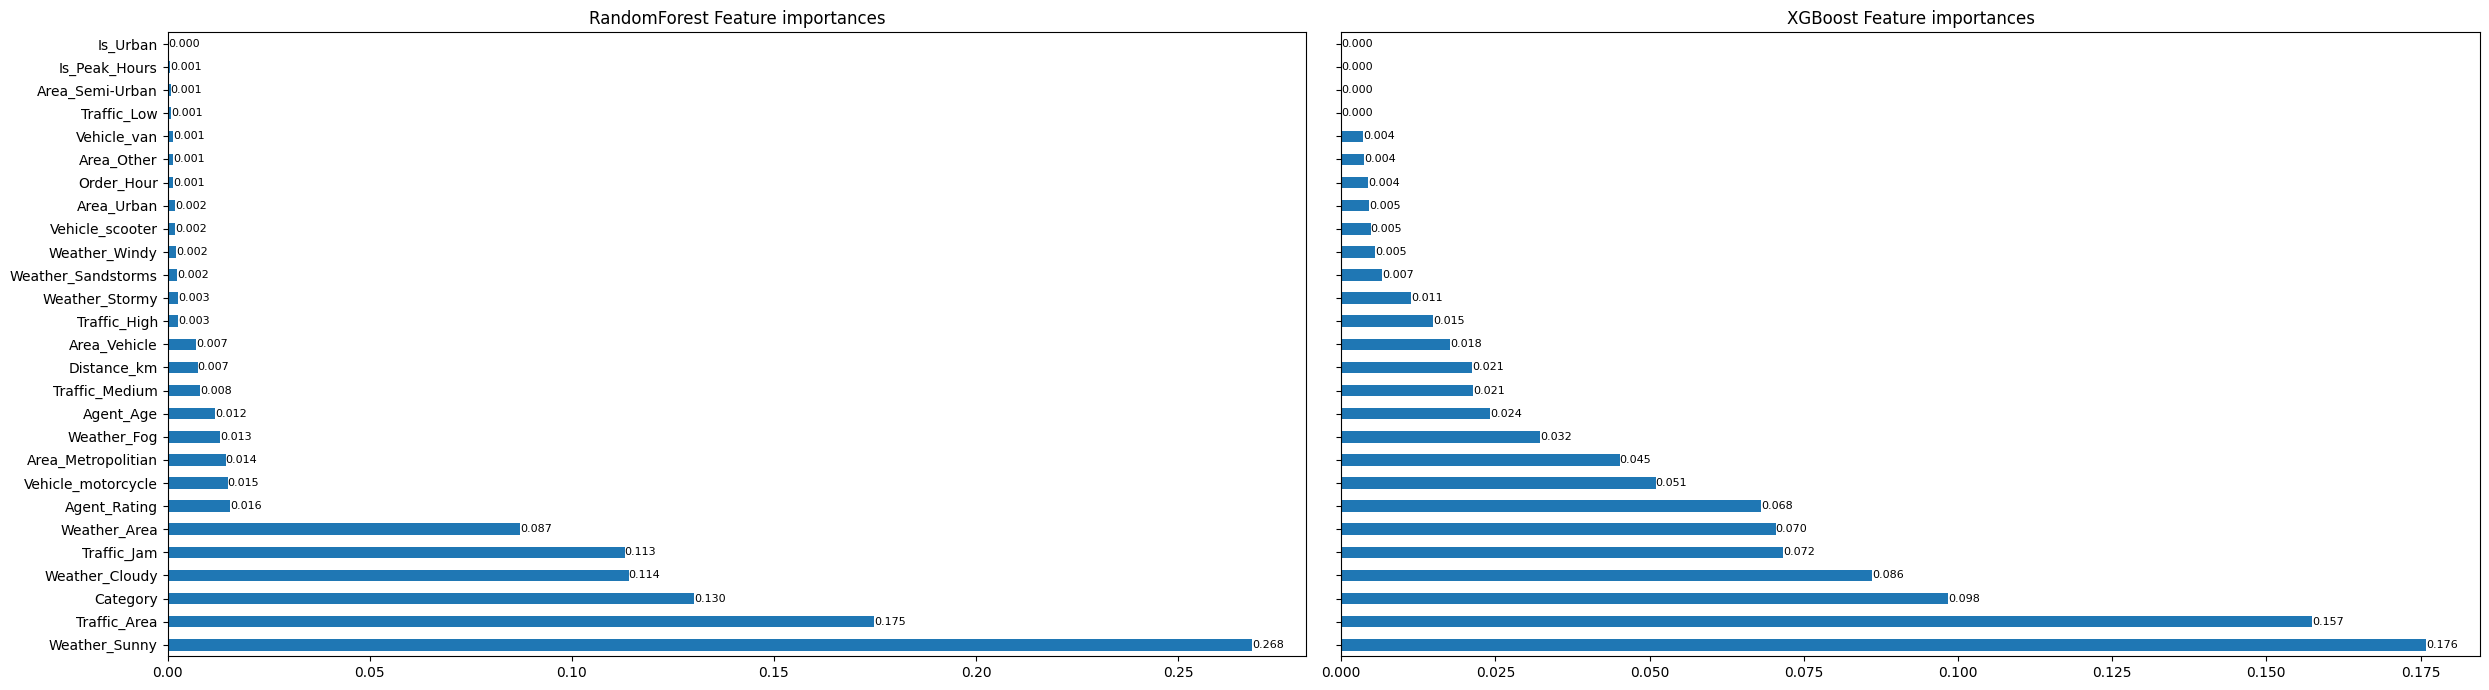

In [14]:
# Get importances
rf_importances  = get_feature_importances(results, "RandomForest")
xgb_importances = get_feature_importances(results, "XGBoost")

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=True)

# RandomForest
rf_top = rf_importances
rf_top.plot(kind="barh", ax=axes[0], title="RandomForest Feature importances")
for i, (val, name) in enumerate(zip(rf_top.values, rf_top.index)):
    axes[0].text(val, i, f"{val:.3f}", va="center", ha="left", fontsize=8)

# XGBoost
xgb_top = xgb_importances
xgb_top.plot(kind="barh", ax=axes[1], title="XGBoost Feature importances")
for i, (val, name) in enumerate(zip(xgb_top.values, xgb_top.index)):
    axes[1].text(val, i, f"{val:.3f}", va="center", ha="left", fontsize=8)

output_dir = "../Reports/Analysis_Images"
os.makedirs(output_dir, exist_ok=True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"Feature_Importance_RF_&_XBG.png".replace(" ", "_")), dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# Function to find common low importance features that can be dropped
def drop_low_importance_features(rf_importances, xgb_importances, threshold=0.01):
    """
    Select common low-importance features from RandomForest & XGBoost
    (importance < threshold in both).
    """
    # Ensure both are DataFrames with feature + importance
    if isinstance(rf_importances, pd.Series):
        rf_importances = rf_importances.reset_index()
        rf_importances.columns = ["feature", "importance"]
    if isinstance(xgb_importances, pd.Series):
        xgb_importances = xgb_importances.reset_index()
        xgb_importances.columns = ["feature", "importance"]

    low_rf  = set(rf_importances[rf_importances["importance"] < threshold]["feature"])
    low_xgb = set(xgb_importances[xgb_importances["importance"] < threshold]["feature"])
    
    # Common weak features → drop
    low_common = low_rf.intersection(low_xgb)
    print(f"Common low-importance features (<{threshold}): {sorted(list(low_common))}")
    
    return list(low_common)

feats_to_drop = drop_low_importance_features(rf_importances, xgb_importances, threshold=0.01)

Common low-importance features (<0.01): ['Area_Other', 'Area_Semi-Urban', 'Area_Urban', 'Is_Peak_Hours', 'Is_Urban', 'Vehicle_scooter', 'Vehicle_van', 'Weather_Sandstorms', 'Weather_Windy']


In [24]:

class PreprocessorWithPostDrop(BaseEstimator, TransformerMixin):
    """
    Composite preprocessor that:
      - optionally drops raw columns (pandas DataFrame),
      - applies outlier_skew and target encoder (both operate on DataFrame),
      - fits a ColumnTransformer (preprocessor) and transforms -> numpy array,
      - converts numpy -> DataFrame using generated feature names,
      - drops engineered feature names (if any),
      - returns numpy array for the model.
    """
    def __init__(self,
                 drop_raw=None,               # list of raw DF columns to remove before anything
                 outlier_skew=None,           # transformer (fit/transform) expecting DataFrame
                 target_encoder=None,         # e.g. category_encoders.TargetEncoder instance
                 preprocessor=None,           # a ColumnTransformer instance (num + ohe,...)
                 engineered_to_drop=None      # list of engineered column names to remove AFTER preproc
                ):
        self.drop_raw = drop_raw or []
        self.outlier_skew = outlier_skew
        self.target_encoder = target_encoder
        self.preprocessor = preprocessor
        self.engineered_to_drop = engineered_to_drop or []

    def fit(self, X, y=None):
        X_ = X.copy()

        # 1) drop raw columns (so the encoders never see them)
        if self.drop_raw:
            X_ = X_.drop(columns=self.drop_raw, errors="ignore")

        # 2) fit & apply outlier_skew (if provided)
        if self.outlier_skew is not None:
            self.outlier_skew_ = clone(self.outlier_skew)
            self.outlier_skew_.fit(X_, y)
            X_ = self.outlier_skew_.transform(X_)

        # 3) fit & apply target encoder (if provided)
        if self.target_encoder is not None:
            self.target_encoder_ = clone(self.target_encoder)
            # target encoder often needs y during fit
            self.target_encoder_.fit(X_, y)
            X_enc = self.target_encoder_.transform(X_)
            # ensure we have a DataFrame with same column names
            if isinstance(X_enc, np.ndarray):
                X_ = pd.DataFrame(X_enc, columns=X_.columns, index=X_.index)
            else:
                X_ = pd.DataFrame(X_enc, columns=X_.columns, index=X_.index)

        # 4) Fit the ColumnTransformer (preprocessor)
        if self.preprocessor is None:
            raise ValueError("preprocessor (ColumnTransformer) must be provided")

        self.preprocessor_ = clone(self.preprocessor)
        # fit with X_ and y (some transformers in ColumnTransformer may require y)
        self.preprocessor_.fit(X_, y)

        # 5) Compute final feature names produced by the ColumnTransformer
        self.feature_names_ = self._get_feature_names_from_column_transformer(self.preprocessor_, X_.columns)

        # 6) determine column indices of engineered_to_drop (if present)
        self._drop_indices = [i for i, name in enumerate(self.feature_names_) if name in self.engineered_to_drop]

        # For logging / inspection, also store the kept feature names after drop
        self.kept_feature_names_ = [n for i,n in enumerate(self.feature_names_) if i not in self._drop_indices]

        return self

    def transform(self, X):
        X_ = X.copy()

        if self.drop_raw:
            X_ = X_.drop(columns=self.drop_raw, errors="ignore")

        if self.outlier_skew is not None:
            X_ = self.outlier_skew_.transform(X_)

        if self.target_encoder is not None:
            X_enc = self.target_encoder_.transform(X_)
            if isinstance(X_enc, np.ndarray):
                X_ = pd.DataFrame(X_enc, columns=X_.columns, index=X_.index)
            else:
                X_ = pd.DataFrame(X_enc, columns=X_.columns, index=X_.index)

        # now transform using the fitted ColumnTransformer => numpy array
        arr = self.preprocessor_.transform(X_)

        # convert to DataFrame so we can drop engineered names by label
        df = pd.DataFrame(arr, columns=self.feature_names_, index=X_.index)

        # drop engineered columns (safe: errors='ignore')
        if self.engineered_to_drop:
            df = df.drop(columns=self.engineered_to_drop, errors="ignore")

        # return numpy array for downstream model
        return df.values

    def _get_feature_names_from_column_transformer(self, col_trans, input_columns):
        """
        Robustly derive feature names from ColumnTransformer after it is fitted.
        Tries to call transformer's get_feature_names_out where available, else falls back.
        input_columns: iterable of original df column names (passed to get_feature_names_out when needed)
        """
        names = []

        # access fitted transformers_ (list of (name, transformer, columns))
        for name, trans, cols in col_trans.transformers_:
            if trans == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    # if cols is list of names, pass it to get_feature_names_out
                    # some transformers require the feature names argument
                    candidate = list(trans.get_feature_names_out(cols))
                except Exception:
                    # fallback: sometimes get_feature_names_out expects input feature names
                    try:
                        candidate = list(trans.get_feature_names_out(input_columns))
                    except Exception:
                        candidate = list(cols) if isinstance(cols, (list, tuple)) else [cols]
            else:
                # passthrough or standard scaler -> keep original column list
                if trans == "passthrough" or hasattr(trans, "transform"):
                    candidate = list(cols) if isinstance(cols, (list, tuple)) else [cols]
                else:
                    candidate = list(cols) if isinstance(cols, (list, tuple)) else [cols]

            # ensure flattened list of strings
            for c in candidate:
                names.append(str(c))
        return names

In [ ]:
# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats + high_card_feats),
        ("ohe", ohe, low_card_feats)
    ],
    remainder="drop"
)

# feats_to_drop is the list of engineered column names you want removed after OHE
raw_to_drop = [f for f in feats_to_drop if f in no_scaling_feats]             # drop these raw before anything
engineered_to_drop = [f for f in feats_to_drop if f not in no_scaling_feats]  # engineered OHE names to remove after preproc

preproc_with_drop = PreprocessorWithPostDrop(
    drop_raw=raw_to_drop,
    outlier_skew=outlier_skew,
    target_encoder=target_enc,
    preprocessor=preprocessor,
    engineered_to_drop=engineered_to_drop
)

final_pipe = Pipeline([
    ("preprocessing", preproc_with_drop),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

# test fit before using in hp tuned model
final_pipe.fit(X_train, y_train)

# get final feature names used by the model
used_feature_names = final_pipe.named_steps["preprocessing"].kept_feature_names_
print("Final features used:", used_feature_names)

Final features used: ['Agent_Age', 'Agent_Rating', 'Distance_km', 'Order_Hour', 'Category', 'Traffic_Area', 'Area_Vehicle', 'Weather_Area', 'Weather_Cloudy', 'Weather_Fog', 'Weather_Stormy', 'Weather_Sunny', 'Traffic_High', 'Traffic_Jam', 'Traffic_Low', 'Traffic_Medium', 'Vehicle_motorcycle', 'Area_Metropolitian']


In [26]:
# Wrapper to attach model
def make_pipeline_reduced(model):
    return Pipeline(steps=[
        ("preprocessing", preproc_with_drop),
        ("model", model)
    ])

#### ***Hyperparameter Tune RF & XGB on reduced Feature set***

In [27]:
# Define Hyperparameter search spaces

# RandomForest param space
rf_param_dist = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt", "log2", None],
}

# XGBoost param space
xgb_param_dist = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__gamma": [0, 0.1, 0.3, 0.5],
    "model__reg_lambda": [0.5, 1, 1.5, 2],
    "model__reg_alpha": [0, 0.01, 0.1, 0.5],
}        

search_spaces = {
    "RandomForest": (RandomForestRegressor(random_state=RANDOM_STATE), rf_param_dist),
    "XGBoost": (xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1), xgb_param_dist),
}

In [29]:
# Run RandomizedSearchCV + MLflow logging

tuned_results = {}

for name, (model, param_dist) in search_spaces.items():
    pipe = make_pipeline_reduced(model)

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=20,             
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    with mlflow.start_run(run_name=f"HP_Tuned_{name}"):
        search.fit(X_train, y_train)

        best_model = search.best_estimator_

        # Predictions
        preds_train = best_model.predict(X_train)
        preds_val = best_model.predict(X_val)

        # Metrics
        train_metrics = metrics_report(y_train, preds_train)
        val_metrics = metrics_report(y_val, preds_val)

        print(f"=== HP Tuned {name} ===")
        print("\nBest Params:", search.best_params_)
        print_eval("Train", y_train, preds_train)
        print_eval("Val", y_val, preds_val)

        # Log metrics & best params
        mlflow.log_params(search.best_params_)
        mlflow.log_metrics({f"train_{k}": v for k, v in train_metrics.items()})
        mlflow.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})

        # Log feature names used
        try:
            preproc = best_model.named_steps["preprocessing"]

            # Our custom PreprocessorWithPostDrop saves kept features
            if hasattr(preproc, "kept_feature_names_"):
                feature_names = preproc.kept_feature_names_
            else:
                # Fallback: just log the count if names unavailable
                feature_names = [f"feature_{i}" for i in range(best_model.named_steps["preprocessing"].transform(X_train).shape[1])]

            feat_dir = "../Reports/features/Hp_tuned"
            os.makedirs(feat_dir, exist_ok=True)
            feat_path = os.path.join(feat_dir, f"{name}_Tuned_features.txt")

            with open(feat_path, "w") as f:
                for col in feature_names:
                    f.write(col + "\n")

            mlflow.log_artifact(feat_path, artifact_path="features")

        except Exception as e:
            print(f"⚠️ Could not extract features for {name}_Tuned: {e}")

        # Log best model
        mlflow.sklearn.log_model(best_model, "Hp_tuned_model")

        # Store results
        tuned_results[name] = {
            "best_model": best_model,
            "best_params": search.best_params_,
            "train_metrics": train_metrics,
            "val_metrics": val_metrics
        }

Fitting 5 folds for each of 20 candidates, totalling 100 fits
=== HP Tuned RandomForest ===

Best Params: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 8, 'model__n_estimators': 443}
Train -> RMSE: 20.7997 | MAE: 16.0840 | R2: 0.8390
Val -> RMSE: 22.1465 | MAE: 17.1485 | R2: 0.8180
Fitting 5 folds for each of 20 candidates, totalling 100 fits
=== HP Tuned XGBoost ===

Best Params: {'model__colsample_bytree': 0.9705203514053395, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__n_estimators': 334, 'model__reg_alpha': 0, 'model__reg_lambda': 2, 'model__subsample': 0.7797802696552814}
Train -> RMSE: 20.5794 | MAE: 15.9690 | R2: 0.8424
Val -> RMSE: 22.3399 | MAE: 17.3514 | R2: 0.8149


In [30]:
# Convert tuned_results into comparison DataFrame
summary = []

for name, res in tuned_results.items():
    row = {
        "Model": name,
        "Train_RMSE": res["train_metrics"]["rmse"],
        "Val_RMSE": res["val_metrics"]["rmse"],
        "Train_MAE": res["train_metrics"]["mae"],
        "Val_MAE": res["val_metrics"]["mae"],
        "Train_R2": res["train_metrics"]["r2"],
        "Val_R2": res["val_metrics"]["r2"]
    }
    summary.append(row)

# Create DataFrame for easy comparison
tuned_results_df = pd.DataFrame(summary)
tuned_results_df = tuned_results_df.set_index("Model")
tuned_results_df = tuned_results_df.sort_values("Val_RMSE")
tuned_results_df

,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_R2,Val_R2
Model,,,,,,
RandomForest,20.799711,22.146511,16.083979,17.148455,0.839050,0.818046
XGBoost,20.579387,22.339939,15.968962,17.351373,0.842441,0.814853


***Validation Performance (what really matters):***
- RandomForest has slightly lower RMSE/MAE → better generalization.
- RF Val_RMSE = 22.15 vs XGB 22.34 (edge to RF).
- RF Val_MAE = 17.14 vs XGB 17.35 (edge to RF).
- Val_R² is very close (RF 0.8180 vs XGB 0.8148).
- Overall, RF generalizes slightly better.

***Training Performance:***
- XGB fits training data better (lower Train_RMSE/MAE, higher Train_R²).
- Train_RMSE: XGB 20.58 vs RF 20.80.
- Train_MAE: XGB 15.97 vs RF 16.08.
- Train_R²: XGB 0.8424 vs RF 0.8390.
- But this small gap suggests XGB may be overfitting a bit more compared to RF.

***✅ Best Choice -> RandomForest***
- Lower validation RMSE/MAE (your main metrics).
- More balanced between Train and Val → less risk of overfitting.

#### ***Retrain on Train + Val with best model parameters***

In [33]:
# Combine Train + Val to create the final train
X_final_train = pd.concat([X_train, X_val], axis=0)
y_final_train = pd.concat([y_train, y_val], axis=0)

# Best hyperparameters from tuning (remove "model__" prefix)
raw_best_params = tuned_results["RandomForest"]["best_params"]
best_params = {k.replace("model__", ""): v for k, v in raw_best_params.items()}

# Build final pipeline
final_model = make_pipeline_reduced(
    RandomForestRegressor(random_state=RANDOM_STATE, **best_params)
)

In [34]:
# Train on full train+val
final_model.fit(X_final_train, y_final_train)

# Evaluate on Train (full train+val)
preds_train_final = final_model.predict(X_final_train)
train_metrics_final = metrics_report(y_final_train, preds_train_final)
print_eval("Final Train", y_final_train, preds_train_final)

# Evaluate on Test
preds_test_final = final_model.predict(X_test)
test_metrics_final = metrics_report(y_test, preds_test_final)
print_eval("Final Test", y_test, preds_test_final)

Final Train -> RMSE: 20.9653 | MAE: 16.2010 | R2: 0.8366
Final Test -> RMSE: 21.9895 | MAE: 16.9840 | R2: 0.8234


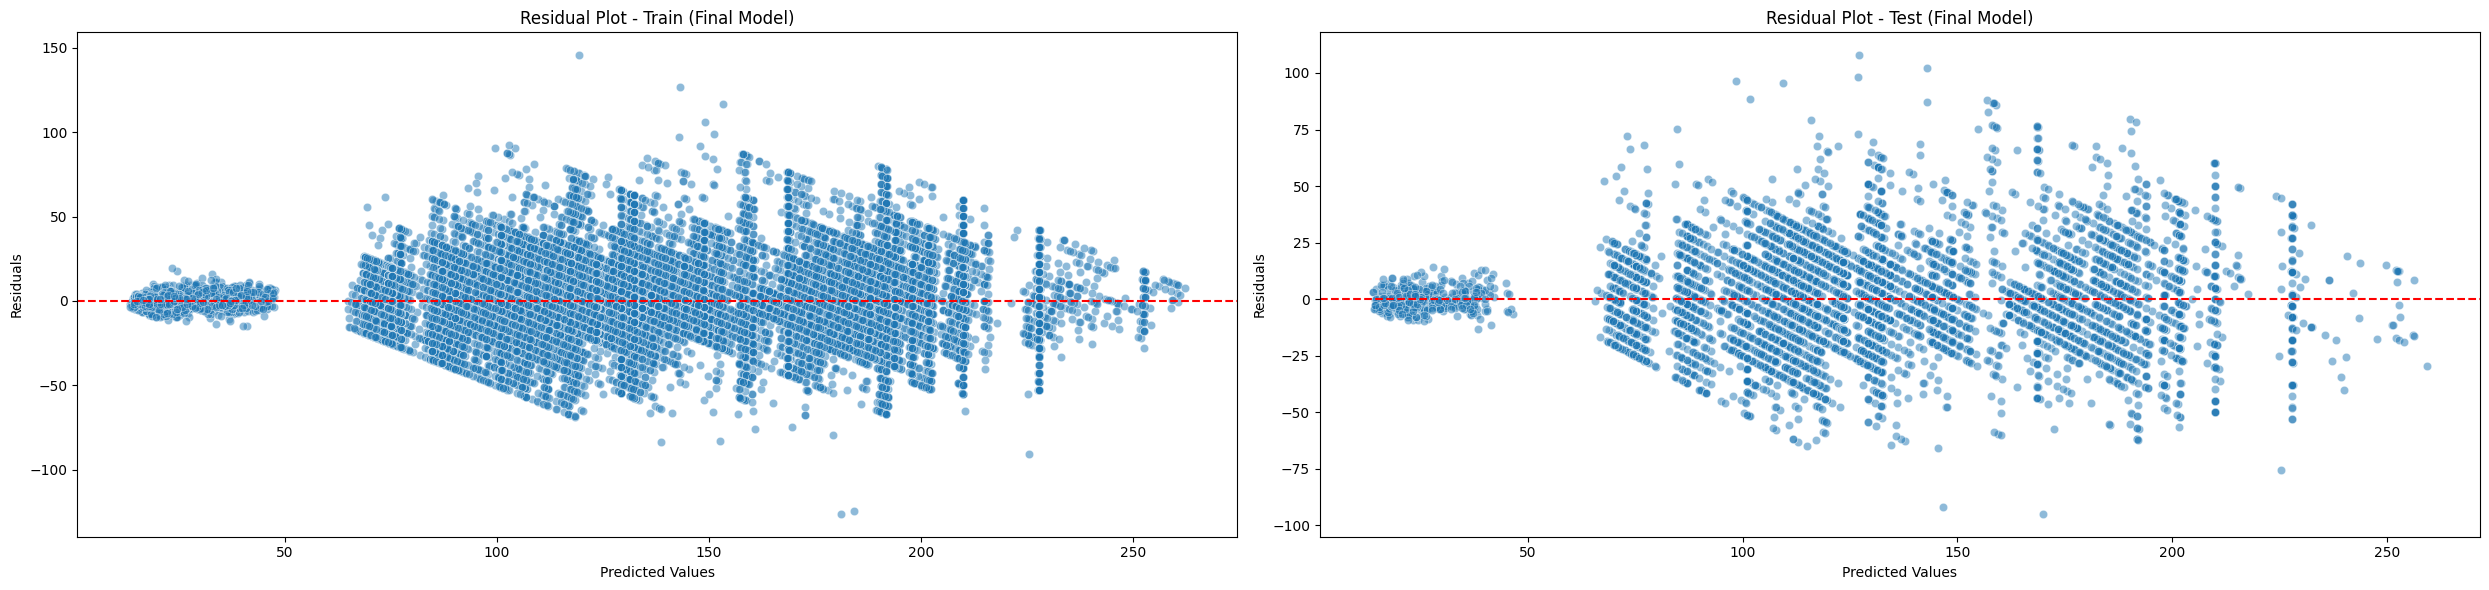

In [37]:
# Compute residuals
residuals_train = y_final_train - preds_train_final
residuals_test = y_test - preds_test_final

# Plot residuals
plt.figure(figsize=(25,6))

# Train residuals
plt.subplot(1,2,1)
sns.scatterplot(x=preds_train_final, y=residuals_train, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Train (Final Model)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Test residuals
plt.subplot(1,2,2)
sns.scatterplot(x=preds_test_final, y=residuals_test, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Test (Final Model)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

#### ***Interpretation***

***Consistency (Good Generalization)***
- Train+Val RMSE = 20.9 vs Test RMSE = 2190 → only a small gap.
- Train+Val R² = 0.83 vs Test R² = 0.82 → very close.
- ✅ Model is not overfitting; generalizes well to unseen data.

***Error Magnitude***
- RMSE ~22 hours → predictions deviate by ~22 hours on average.
- MAE ~17 hours → median absolute error is lower (robust to outliers).
- Considering delivery times may range widely (short vs long trips), this error seems reasonable — since long-distance orders exist.

***Residual Plot***
- Residuals are mostly centered around 0 (good).
- Spread increases with higher predicted values (heteroscedasticity).
- Suggests model handles short/medium deliveries better, but variance grows for long delivery times (common in real logistics data).

***Conclusion***
- Hyperparameter tuned RandomForest model is performing very well
- Balanced fit (Train ≈ Test metrics).
- Captures ~82% of variance in delivery times.
- Errors are relatively stable across test set.

In [38]:
# Log everything in MLflow
with mlflow.start_run(run_name="Final_RF_Model"):

    # Params
    mlflow.log_params(best_params)

    # Metrics
    mlflow.log_metrics({f"train_{k}": v for k, v in train_metrics_final.items()})
    mlflow.log_metrics({f"test_{k}": v for k, v in test_metrics_final.items()})

    # Log model
    mlflow.sklearn.log_model(final_model, "Final_RF_Model")

    # Log final feature names
    try:
        feature_names = final_model.named_steps["preprocessing"].kept_feature_names_
    except AttributeError:
        feature_names = []

    feat_dir = "../Reports/features/Final"
    os.makedirs(feat_dir, exist_ok=True)
    feat_path = os.path.join(feat_dir, "Final_RF_features.txt")
    with open(feat_path, "w") as f:
        for col in feature_names:
            f.write(col + "\n")
    mlflow.log_artifact(feat_path, artifact_path="features")

print(f"✅ Final model, metrics and parameters logged to MLflow/DagsHub")

✅ Final model, metrics and parameters logged to MLflow/DagsHub


In [ ]:
# Use tags to indicate champion/production for registered models
client = mlflow.tracking.MlflowClient()

client.set_model_version_tag(
    name="AmazonDelivery_RF_Final",
    version="1",
    key="stage",
    value="production"
)

***Model is now registered in MLflow & is ready for production***